<a href="https://colab.research.google.com/github/mavito/hello-world/blob/master/pytorch_csv_card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir /content/cards

mkdir: cannot create directory ‘/content/cards’: File exists


In [2]:
cd /content/cards

/content/cards


In [3]:
#!rm -rf /content/cards

In [17]:
#data in csv tensorflow object detection format
!curl -L "https://app.roboflow.com/ds/9coDs0EIRt?key=r6eFuZHb7b" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   893  100   893    0     0   1807      0 --:--:-- --:--:-- --:--:--  1804
100 15.5M  100 15.5M    0     0  23.7M      0 --:--:-- --:--:-- --:--:-- 23.7M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: train/
 extracting: train/15699492781_jpeg.rf.3e8255a4abc780cea7441cd00fc86c01.jpg  
 extracting: train/15699492781_jpeg.rf.692f131ede4b35538beeb48973661e49.jpg  
 extracting: train/15699492781_jpeg.rf.833a447a4015cc71f783a0f8b11e83df.jpg  
 extracting: train/Archit_aadhar_png.rf.0d580759bc036c7a32cad631f0e2d82b.jpg  
 extracting: train/Archit_aadhar_png.rf.52dcc8df908dd73fab5fe56157dc92ed.jpg  
 extracting: train/Archit_aadhar_png.rf.f4b5d7e4bd64e598ee0f1b4f9dc9327f.jpg  
 extracting: train/OB13218001_PhotoIdProof_25082020_25411_jpeg.rf.28c2ab63a5b8ac744182964667bc595b.jpg  
 extracting: train/OB132180

In [5]:
cd ..

/content


In [6]:
import numpy as np 
import pandas as pd
import shutil
import cv2
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import json
import os
import glob

import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
df = pd.read_csv('/content/cards/train/_annotations.csv')
class_to_dict = {c:i for i, c in enumerate(df['class'].unique())}
df['class'] = df['class'].map(class_to_dict)
df.to_csv('/content/cards/train/new_annotations.csv')

In [8]:
root = '/content/cards/train'

In [9]:
class MyDataset(Dataset):
    def __init__(self, annotation_file):
        super().__init__()
        self.train_df = pd.read_csv(annotation_file)
        self.image_ids = self.train_df['filename'].unique()

    def __getitem__(self, index:int):
        image_id = self.image_ids[index]
        bboxes = self.train_df[self.train_df['filename'] == image_id]
        
        image = cv2.imread(f'{root}/{image_id}',cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = bboxes[['xmin','ymin','xmax','ymax']].values
        area = (boxes[:,3] - boxes[:, 1]) * (boxes[:,2] - boxes[:, 0])

        boxes = torch.as_tensor(boxes,dtype=torch.float32)
        area = torch.as_tensor(area,dtype=torch.float32)

        labels = torch.as_tensor(bboxes['class'].values,dtype = torch.int64)
        iscrowd = torch.zeros((bboxes.shape[0],),dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        image = torchvision.transforms.ToTensor()(image)
        return image, target

    def __len__(self)-> int:
      return self.image_ids.shape[0]

train_dataset = MyDataset('/content/cards/train/new_annotations.csv')

In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

(256, 256, 3)
<class 'numpy.ndarray'>


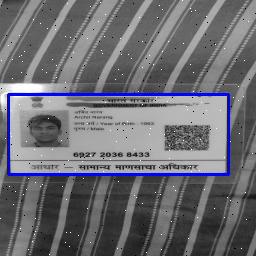

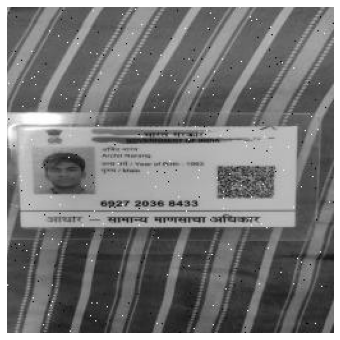

In [26]:
images,targets = next(iter(train_data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
img = images[0].permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1,1,figsize=(12,6))

print(img.shape)
print(type(boxes))
imgc = cv2.cvtColor(img*255, cv2.COLOR_RGB2BGR)
for box in boxes:
  cv2.rectangle(imgc,(box[0],box[1]),(box[2],box[3]),(255, 0, 0),2)

cv2_imshow(imgc)

ax.set_axis_off()
ax.imshow(img)

In [27]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 6
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)

In [15]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

num_epochs = 2

In [16]:
itr = 1

for epoch in range(num_epochs):
  for (image, targets) in tqdm(train_data_loader):
    images = list(image for image in images)
    targets = [{k: v for k, v in t.items()} for t in targets]

    loss_dict = model(images,targets)

    losses = sum(loss for loss in loss_dict.values())
    loss_value = losses.item()

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    if itr%50 ==0:
      print(f'Iteration #{itr} loss:{loss_value}')
    
    itr+=1

    lr_scheduler.step()
  print(f'Epoch #{epoch} loss: {loss_value}')

torch.save(model.state_dict(),'/content/model_cards.pth')
torch.save({
    'epoch':epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict':optimizer.state_dict(),
},'/content/checkpoint.pth')

  2%|▏         | 1/51 [02:27<2:02:56, 147.53s/it]

KeyboardInterrupt: ignored